# Sea Ice Diagnostics for two CESM3 runs

In [1]:
import os

import xarray as xr
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import nc_time_axis

In [2]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
serial = False  # use dask LocalCluster

case_name = "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"

start_date = "0001-01-01"
end_date = "0101-01-01"
base_start_date = "0001-01-01"
base_end_date = "0101-01-01"

climo_nyears = 35
grid_file = "/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc"
path_nsidc = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/ice/analysis_datasets/hemispheric_data/NSIDC_SeaIce_extent"

lc_kwargs = {}

hist = 0

In [3]:
# Parameters
case_name = "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0101-01-01"
base_start_date = "0001-01-01"
base_end_date = "0101-01-01"
lc_kwargs = {"threads_per_worker": 1}
serial = False
climo_nyears = 35
grid_file = "/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc"
path_nsidc = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/ice/analysis_datasets/hemispheric_data/NSIDC_SeaIce_extent"
subset_kwargs = {}
product = "/glade/work/samrabin/cupid_crops/examples/key_metrics/computed_notebooks//ice/Hemis_seaice_visual_compare_obs_lens.ipynb"


In [4]:
cupid_run = 1

if cupid_run == 1:

    from dask.distributed import Client, LocalCluster

    # Spin up cluster (if running in parallel)
    client = None
    if not serial:
        cluster = LocalCluster(**lc_kwargs)
        client = Client(cluster)

else:

    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster(
        cores=16,
        processes=16,
        memory="100GB",
        account="P93300065",
        queue="casper",
        walltime="02:00:00",
    )

    client = Client(cluster)

    cluster.scale(1)

    print(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33881,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:46705,Total threads: 1
Dashboard: http://127.0.0.1:43931/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:40455,


In [5]:
# Read in two cases. The ADF timeseries are needed here.

ds1 = xr.open_mfdataset(
    os.path.join(
        CESM_output_dir, case_name, "ice", "proc", "tseries", f"{case_name}.cice.h.*.nc"
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(start_date, end_date))
ds2 = xr.open_mfdataset(
    os.path.join(
        CESM_output_dir,
        base_case_name,
        "ice",
        "proc",
        "tseries",
        f"{base_case_name}.cice.h.*.nc",
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(base_start_date, base_end_date))

ds_grid = xr.open_dataset(grid_file)
TLAT = ds_grid["TLAT"]
TLON = ds_grid["TLONG"]
tarea = ds_grid["TAREA"] * 1.0e-4
angle = ds_grid["ANGLE"]

ds1_ann = ds1.resample(time="YS").mean(dim="time")
ds2_ann = ds2.resample(time="YS").mean(dim="time")

with open("cice_masks.yml", "r") as file:
    cice_masks = yaml.safe_load(file)

In [6]:
### Read in the CESM1 and CESM2 LE sea ice area

# cesm1_path = "/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/aice/"

# ds_cesm1_nh = xr.open_dataset(cesm1_path + "b.e11.B1850C5CN.f09_g16.005.cice.h.aice_nh.210001-220012.nc")
# ds_cesm1_sh = xr.open_dataset(cesm1_path + "b.e11.B1850C5CN.f09_g16.005.cice.h.aice_sh.210001-220012.nc")

# cesm2_path = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/ice/proc/tseries/month_1/"
# cesm2_ds = xr.open_dataset(cesm2_path + "b.e21.B1850.f09_g17.CMIP6-piControl.001.cice.h.aice.190001-200012.nc")

# nj_nh = ds_cesm1_nh['nj']
# nj_sh = ds_cesm2_sh['nh']

# aice_cesm1 = cesm2_ds['aice']

# aice_cesm1 = 0.0
# aice_cesm1[:,0:nj_sh-1,:] = ds_cesm1_sh['aice']
# aice_cesm1[:,383-nj_nh:383,:] = ds_cesm1_nh['aice']

In [7]:
# Two functions to help draw plots even if only one year of data is available
# If one year is present, horizontal line will be dotted instead of solid


def da_plot_len_time_might_be_one(da_in, alt_time):
    # If da_in.time only has 1 value, draw horizontal line across range of alt_time
    if len(da_in.time) > 1:
        da_in.plot()
    else:
        time_arr = [alt_time.data[0], alt_time.data[-1]]
        plt.plot(time_arr, [da_in.data[0], da_in.data[0]], linestyle=":")


def plt_plot_len_x_might_be_one(da_in, x_in, alt_x):
    # If x_in only has one value, draw horizontal line across range of alt_x
    if len(x_in) > 1:
        plt.plot(x_in, da_in)
    else:
        plt.plot([alt_x[0], alt_x[-1]], [da_in.data[0], da_in.data[0]], linestyle=":")

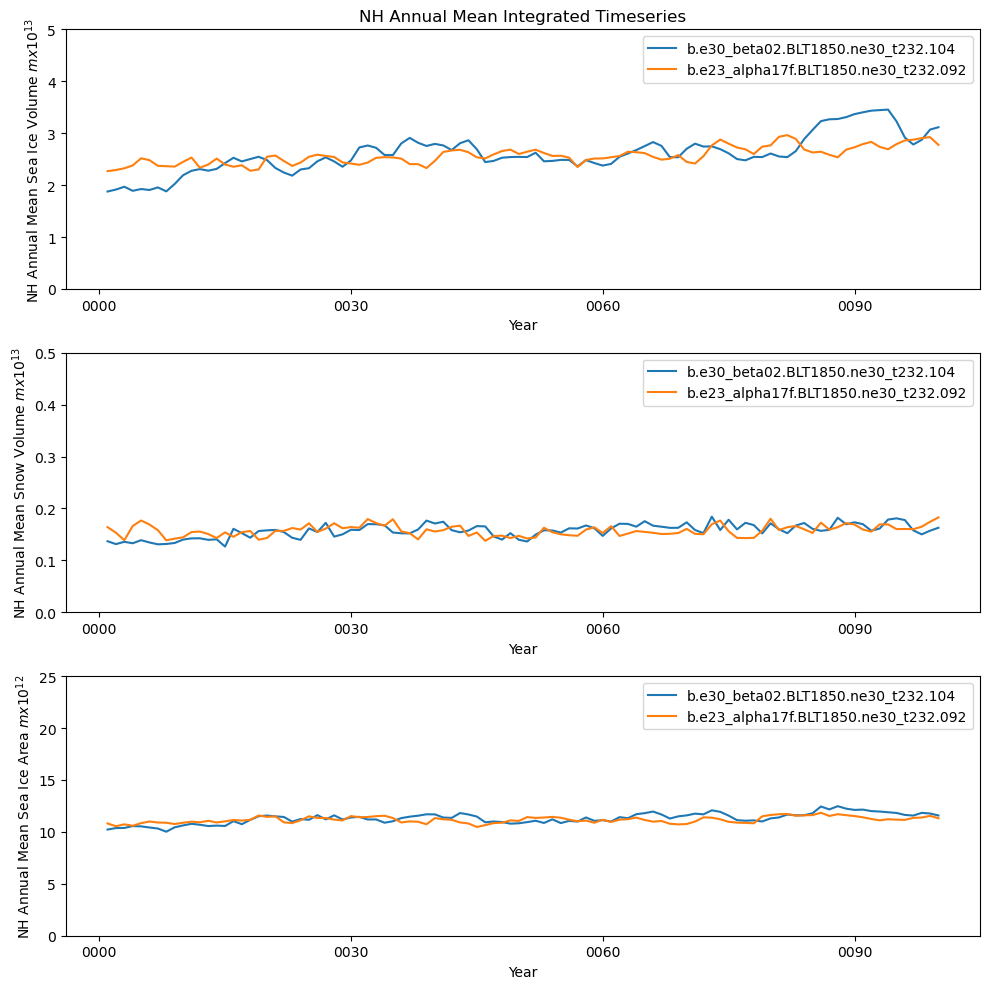

In [8]:
ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
da_plot_len_time_might_be_one(ds1_vhi_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_vhi_ann, alt_time=ds1_ann.time)

plt.title("NH Annual Mean Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Volume $m x 10^{13}$")
plt.legend([case_name, base_case_name])

ax = fig.add_subplot(3, 1, 2)
da_plot_len_time_might_be_one(ds1_vhs_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_vhs_ann, alt_time=ds1_ann.time)

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Snow Volume $m x 10^{13}$")
plt.legend([case_name, base_case_name])

ax = fig.add_subplot(3, 1, 3)
da_plot_len_time_might_be_one(ds1_area_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_area_ann, alt_time=ds1_ann.time)

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case_name, base_case_name])

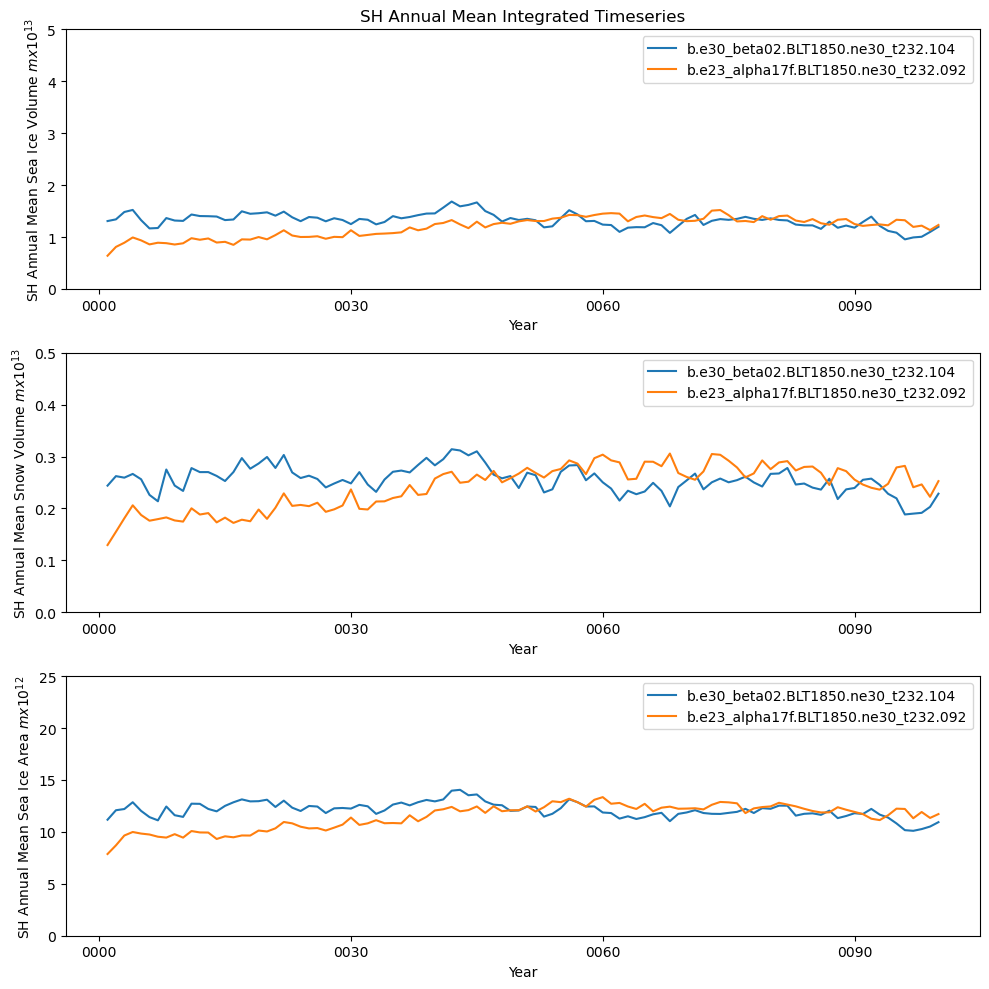

In [9]:
ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
da_plot_len_time_might_be_one(ds1_vhi_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_vhi_ann, alt_time=ds1_ann.time)

plt.title("SH Annual Mean Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel("SH Annual Mean Sea Ice Volume $m x 10^{13}$")
plt.legend([case_name, base_case_name])

ax = fig.add_subplot(3, 1, 2)
da_plot_len_time_might_be_one(ds1_vhs_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_vhs_ann, alt_time=ds1_ann.time)

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel("SH Annual Mean Snow Volume $m x 10^{13}$")
plt.legend([case_name, base_case_name])

ax = fig.add_subplot(3, 1, 3)
da_plot_len_time_might_be_one(ds1_area_ann, alt_time=ds2_ann.time)
da_plot_len_time_might_be_one(ds2_area_ann, alt_time=ds1_ann.time)

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("SH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case_name, base_case_name])

In [10]:
### Read in the NSIDC data from files

jan_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_01_extent_v3.0.csv"), na_values=["-99.9"]
)
feb_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_02_extent_v3.0.csv"), na_values=["-99.9"]
)
mar_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_03_extent_v3.0.csv"), na_values=["-99.9"]
)
apr_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_04_extent_v3.0.csv"), na_values=["-99.9"]
)
may_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_05_extent_v3.0.csv"), na_values=["-99.9"]
)
jun_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_06_extent_v3.0.csv"), na_values=["-99.9"]
)
jul_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_07_extent_v3.0.csv"), na_values=["-99.9"]
)
aug_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_08_extent_v3.0.csv"), na_values=["-99.9"]
)
sep_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_09_extent_v3.0.csv"), na_values=["-99.9"]
)
oct_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_10_extent_v3.0.csv"), na_values=["-99.9"]
)
nov_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_11_extent_v3.0.csv"), na_values=["-99.9"]
)
dec_nsidc = pd.read_csv(
    os.path.join(path_nsidc, "N_12_extent_v3.0.csv"), na_values=["-99.9"]
)

jan_area = jan_nsidc.iloc[:, 5].values
feb_area = feb_nsidc.iloc[:, 5].values
mar_area = mar_nsidc.iloc[:, 5].values
apr_area = apr_nsidc.iloc[:, 5].values
may_area = may_nsidc.iloc[:, 5].values
jun_area = jun_nsidc.iloc[:, 5].values
jul_area = jul_nsidc.iloc[:, 5].values
aug_area = aug_nsidc.iloc[:, 5].values
sep_area = sep_nsidc.iloc[:, 5].values
oct_area = oct_nsidc.iloc[:, 5].values
nov_area = nov_nsidc.iloc[:, 5].values
dec_area = dec_nsidc.iloc[:, 5].values

jan_ext = jan_nsidc.iloc[:, 4].values
feb_ext = feb_nsidc.iloc[:, 4].values
mar_ext = mar_nsidc.iloc[:, 4].values
apr_ext = apr_nsidc.iloc[:, 4].values
may_ext = may_nsidc.iloc[:, 4].values
jun_ext = jun_nsidc.iloc[:, 4].values
jul_ext = jul_nsidc.iloc[:, 4].values
aug_ext = aug_nsidc.iloc[:, 4].values
sep_ext = sep_nsidc.iloc[:, 4].values
oct_ext = oct_nsidc.iloc[:, 4].values
nov_ext = nov_nsidc.iloc[:, 4].values
dec_ext = dec_nsidc.iloc[:, 4].values

nsidc_clim = [
    np.nanmean(jan_ext[0:35]),
    np.nanmean(feb_ext[0:35]),
    np.nanmean(mar_ext[0:35]),
    np.nanmean(apr_ext[0:35]),
    np.nanmean(may_ext[0:35]),
    np.nanmean(jun_ext[0:35]),
    np.nanmean(jul_ext[0:35]),
    np.nanmean(aug_ext[0:35]),
    np.nanmean(sep_ext[0:35]),
    np.nanmean(oct_ext[0:35]),
    np.nanmean(nov_ext[0:35]),
    np.nanmean(dec_ext[0:35]),
]

# plt.plot(nsidc_clim)

In [11]:
### Read in the SH NSIDC data from files

jan_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_01_extent_v3.0.csv"), na_values=["-99.9"]
)
feb_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_02_extent_v3.0.csv"), na_values=["-99.9"]
)
mar_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_03_extent_v3.0.csv"), na_values=["-99.9"]
)
apr_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_04_extent_v3.0.csv"), na_values=["-99.9"]
)
may_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_05_extent_v3.0.csv"), na_values=["-99.9"]
)
jun_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_06_extent_v3.0.csv"), na_values=["-99.9"]
)
jul_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_07_extent_v3.0.csv"), na_values=["-99.9"]
)
aug_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_08_extent_v3.0.csv"), na_values=["-99.9"]
)
sep_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_09_extent_v3.0.csv"), na_values=["-99.9"]
)
oct_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_10_extent_v3.0.csv"), na_values=["-99.9"]
)
nov_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_11_extent_v3.0.csv"), na_values=["-99.9"]
)
dec_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_12_extent_v3.0.csv"), na_values=["-99.9"]
)

jan_area_sh = jan_nsidc_sh.iloc[:, 5].values
feb_area_sh = feb_nsidc_sh.iloc[:, 5].values
mar_area_sh = mar_nsidc_sh.iloc[:, 5].values
apr_area_sh = apr_nsidc_sh.iloc[:, 5].values
may_area_sh = may_nsidc_sh.iloc[:, 5].values
jun_area_sh = jun_nsidc_sh.iloc[:, 5].values
jul_area_sh = jul_nsidc_sh.iloc[:, 5].values
aug_area_sh = aug_nsidc_sh.iloc[:, 5].values
sep_area_sh = sep_nsidc_sh.iloc[:, 5].values
oct_area_sh = oct_nsidc_sh.iloc[:, 5].values
nov_area_sh = nov_nsidc_sh.iloc[:, 5].values
dec_area_sh = dec_nsidc_sh.iloc[:, 5].values

jan_ext_sh = jan_nsidc_sh.iloc[:, 4].values
feb_ext_sh = feb_nsidc_sh.iloc[:, 4].values
mar_ext_sh = mar_nsidc_sh.iloc[:, 4].values
apr_ext_sh = apr_nsidc_sh.iloc[:, 4].values
may_ext_sh = may_nsidc_sh.iloc[:, 4].values
jun_ext_sh = jun_nsidc_sh.iloc[:, 4].values
jul_ext_sh = jul_nsidc_sh.iloc[:, 4].values
aug_ext_sh = aug_nsidc_sh.iloc[:, 4].values
sep_ext_sh = sep_nsidc_sh.iloc[:, 4].values
oct_ext_sh = oct_nsidc_sh.iloc[:, 4].values
nov_ext_sh = nov_nsidc_sh.iloc[:, 4].values
dec_ext_sh = dec_nsidc_sh.iloc[:, 4].values

nsidc_clim_sh = [
    np.nanmean(jan_ext_sh[0:35]),
    np.nanmean(feb_ext_sh[0:35]),
    np.nanmean(mar_ext_sh[0:35]),
    np.nanmean(apr_ext_sh[0:35]),
    np.nanmean(may_ext_sh[0:35]),
    np.nanmean(jun_ext_sh[0:35]),
    np.nanmean(jul_ext_sh[0:35]),
    np.nanmean(aug_ext_sh[0:35]),
    np.nanmean(sep_ext_sh[0:35]),
    np.nanmean(oct_ext_sh[0:35]),
    np.nanmean(nov_ext_sh[0:35]),
    np.nanmean(dec_ext_sh[0:35]),
]

# plt.plot(nsidc_clim_sh)

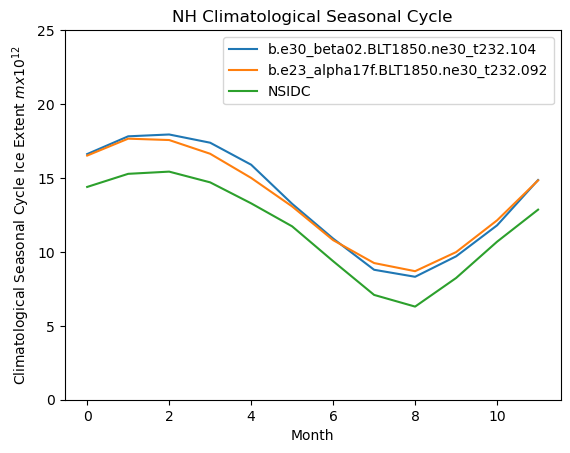

In [12]:
aice1_month = (
    ds1["aice"]
    .isel(time=slice(-climo_nyears, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
aice2_month = (
    ds2["aice"]
    .isel(time=slice(-climo_nyears, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
mask_tmp1 = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2 = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)

mask_ext1 = xr.DataArray(data=mask_tmp1, dims=["month", "nj", "ni"])
mask_ext2 = xr.DataArray(data=mask_tmp2, dims=["month", "nj", "ni"])


ext1 = (mask_ext1 * tarea).sum(["ni", "nj"]) * 1.0e-12
ext2 = (mask_ext2 * tarea).sum(["ni", "nj"]) * 1.0e-12

plt.plot(ext1)
plt.plot(ext2)
plt.plot(nsidc_clim)

plt.title("NH Climatological Seasonal Cycle")
plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("Climatological Seasonal Cycle Ice Extent $m x 10^{12}$")
plt.legend([case_name, base_case_name, "NSIDC"])

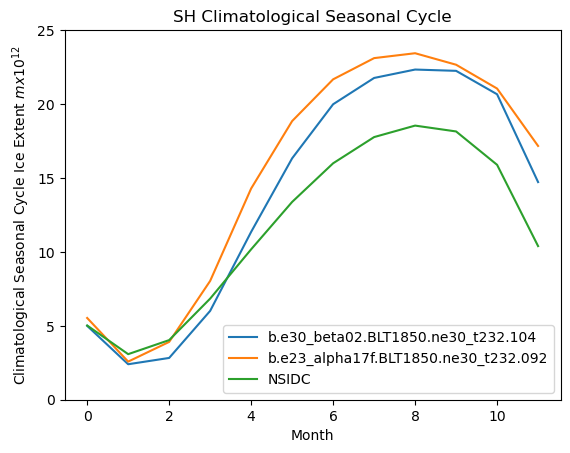

In [13]:
mask_tmp1_sh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)

mask_ext1_sh = xr.DataArray(data=mask_tmp1_sh, dims=["month", "nj", "ni"])
mask_ext2_sh = xr.DataArray(data=mask_tmp2_sh, dims=["month", "nj", "ni"])


ext1_sh = (mask_ext1_sh * tarea).sum(["ni", "nj"]) * 1.0e-12
ext2_sh = (mask_ext2_sh * tarea).sum(["ni", "nj"]) * 1.0e-12

plt.plot(ext1_sh)
plt.plot(ext2_sh)
plt.plot(nsidc_clim_sh)

plt.title("SH Climatological Seasonal Cycle")
plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("Climatological Seasonal Cycle Ice Extent $m x 10^{12}$")
plt.legend([case_name, base_case_name, "NSIDC"])

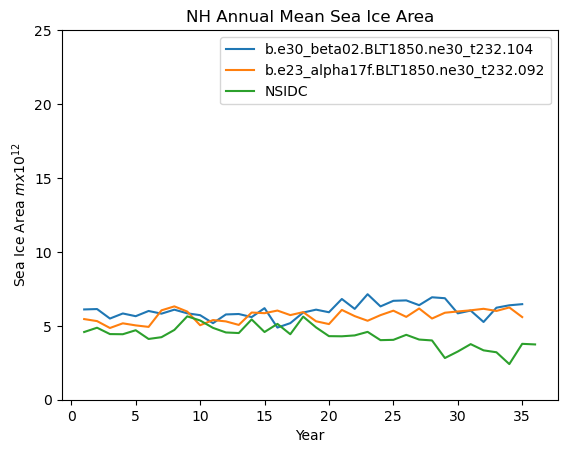

In [14]:
ds1_area = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

x1 = np.linspace(1, len(ds1_sep.time), len(ds1_sep.time))
x2 = np.linspace(1, len(ds2_sep.time), len(ds2_sep.time))
x3 = np.linspace(1, 36, 36)

plt_plot_len_x_might_be_one(ds1_sep, x1, x2)
plt_plot_len_x_might_be_one(ds2_sep, x2, x1)
plt.plot(x3, sep_area[0:36])

plt.title("NH Annual Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $mx10^{12}$")
plt.legend([case_name, base_case_name, "NSIDC"])

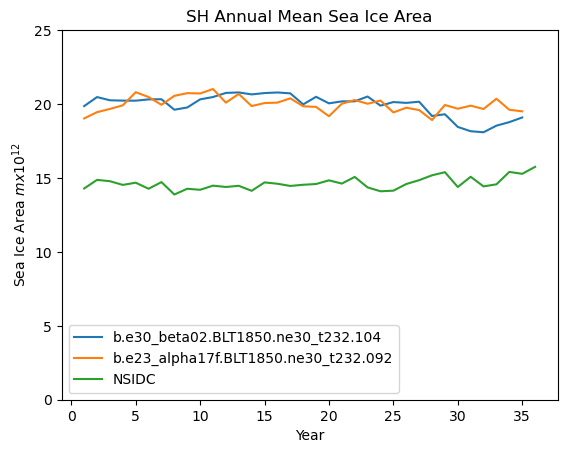

In [15]:
ds1_area_sh = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_sh = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_feb_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 2))
ds2_feb_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 2))

ds1_sep_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 9))
ds2_sep_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 9))

x1 = np.linspace(1, len(ds1_sep.time), len(ds1_sep.time))
x2 = np.linspace(1, len(ds2_sep.time), len(ds2_sep.time))
x3 = np.linspace(1, 36, 36)

plt_plot_len_x_might_be_one(ds1_sep_sh, x1, x2)
plt_plot_len_x_might_be_one(ds2_sep_sh, x2, x1)
plt.plot(x3, sep_area_sh[0:36])

plt.title("SH Annual Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $mx10^{12}$")
plt.legend([case_name, base_case_name, "NSIDC"])

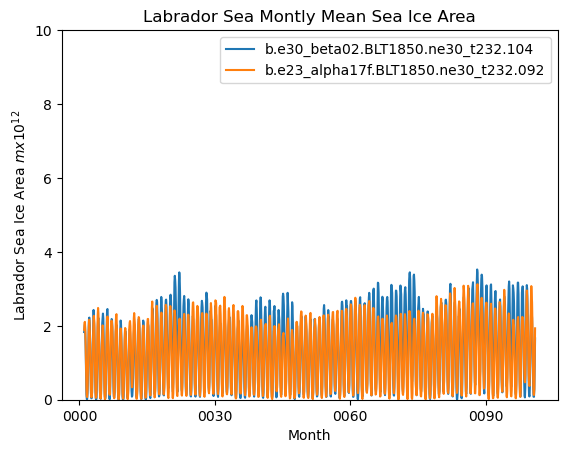

In [16]:
latm = cice_masks["Lab_lat"]
lonm = cice_masks["Lab_lon"]

lon = np.where(TLON < 0, TLON + 360.0, TLON)
mask1 = np.where(np.logical_and(TLAT > latm[0], TLAT < latm[1]), 1.0, 0.0)
mask2 = np.where(np.logical_or(lon > lonm[0], lon < lonm[1]), 1.0, 0.0)
mask = mask1 * mask2

ds1_lab = (mask * tarea * ds1.aice).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_lab = (mask * tarea * ds2.aice).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_lab.plot()
ds2_lab.plot()

plt.title("Labrador Sea Montly Mean Sea Ice Area")
plt.ylim((0, 10))
plt.xlabel("Month")
plt.ylabel("Labrador Sea Ice Area $m x 10^{12}$")
plt.legend([case_name, base_case_name])